# Resting-State fMRI Analysis in R
### From Preprocessed Data to Functional Connectivity

**Authors**: 
Giulia Baracchini and Monika Doerig

### Citation and Resources:

#### Tools included in this workflow
__R__:
- R Core Team. (2025). R: A language and environment for statistical computing (Version 4.4.3) [Software]. R Foundation for Statistical Computing. [https://www.R-project.org/](https://www.R-project.org/)

#### Workflows this work is based on
Original work from Giulia Baracchini: 
- [Resting-state fMRI: From raw data to analyses](https://github.com/giuliabaracc/teaching_fMRI/blob/main/fMRI_restpreprocnet.html)
- [teaching_fMRI](https://github.com/giuliabaracc/teaching_fMRI/blob/main/code/Tutorial_fMRI_complete.R)


#### Dataset
__HCP__
- [3T young adults resting-state dataset](https://www.humanconnectome.org/study/hcp-young-adult/data-releases)

__Schefer parcellation__
- [ThomasYeoLab](https://github.com/ThomasYeoLab/CBIG/tree/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal)


## Introduction

This notebook is adapted from Giulia Baracchini's comprehensive fMRI preprocessing tutorial ([available on GitHub](https://github.com/giuliabaracc/teaching_fMRI/blob/main/fMRI_restpreprocnet.html)), which covers the essential steps of resting-state fMRI analysis from raw data preprocessing through functional connectivity analyses.

The original tutorial provides a complete pipeline covering:

1. **Standard fMRI preprocessing** - preparing raw neuroimaging data for analysis
2. **Resting-state fMRI denoising** - removing artifacts and noise from the signal
3. **Time-series extraction and parcellation** - converting voxel-level data to meaningful brain regions
4. **Functional connectivity analyses** - examining statistical relationships between brain regions

## What This Notebook Covers

While the original tutorial works with multiple subjects and uses the Schaefer 200 region-7 network parcellation, this notebook focuses on a single-subject analysis using the **Schaefer 200 region-17 network** parcellation applied to subject 101309. 

### Key Concepts

**Parcellation**: The process of grouping individual voxels into meaningful brain regions or "parcels." Instead of analyzing thousands of individual voxels, we average signals within anatomically or functionally defined regions, making our analyses more interpretable and computationally manageable.

**Functional Connectivity (FC)**: A statistical measure (typically Pearson's correlation) that quantifies how synchronously different brain regions activate during rest. The result is a region × region matrix where each entry represents the strength of correlation between two brain areas.

### Analysis Pipeline

This notebook focuses on the **analysis phase** using already preprocessed and parcellated data. Starting with clean time series data from 200 brain regions, we implement:

1. **Data normalization** - standardizing time series signals across regions
2. **Functional connectivity calculation** - computing correlation matrices between brain regions  
3. **Fisher z-transformation** - normalizing correlation values for statistical analysis
4. **Network visualization** - creating heatmaps and brain plots to visualize connectivity patterns
5. **Nodal strength analysis** - quantifying each region's overall connectivity
6. **Structure-function relationships** - relating connectivity patterns to brain organization gradients and gene expression patterns

The Schaefer parcellation we're using divides the brain into 200 regions across 17 functional networks, providing a good balance between spatial resolution and interpretability for resting-state connectivity analyses.sting-state connectivity analyses.

<div style="background-color:#fff3cd; border-left:4px solid #ff9800; padding:15px; margin:20px 0;">
⚠️ <strong>Setup Requirements:</strong> Before running this notebook, please complete the following steps

1. **Create an R environment** (in terminal or within the notebook): Set up a Conda/Mamba environment with an R Kernel following these <a href="https://neurodesk.org/tutorials-examples/tutorials/programming/conda/" target="_blank">instructions</a>
2. **Select the R Kernel**: In Jupyter notebook, change the kernel to R (top-right corner `Switch Kernel` or via Kernel menu --> `Change Kernel...`)
3. **Install R packages**: Run the package installation code cells in this notebook
4. **Run the analysis**: Execute the remaining cells to perform the fMRI connectivity analysis

<strong>Note:</strong> This notebook is automatically tested with GitHub Actions and rendered on GitHub Pages, ensuring all code examples work correctly with the specified environment setup.
</div>

## Install and import R packages

In [ ]:
install.packages(c(
  "sf", "units", "s2", "remotes",
  "ggplot2", "dplyr", "tidyr",
  "devtools", "superheat"
))

In [2]:
remotes::install_github("ggseg/ggseg" , upgrade = "never")
remotes::install_github("ggseg/ggsegSchaefer", upgrade = "never")

── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpYwzhBb/remotes33f7e5611a1bee/ggseg-ggseg-e2ad8b4/DESCRIPTION’ ... OK
* preparing ‘ggseg’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘ggseg_1.6.6.tar.gz’




Installing 6 packages: data.table, crosstalk, lazyeval, httr, plotly, ggseg3d

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpYwzhBb/remotes33f7e54850bf74/ggseg-ggsegSchaefer-91bb220/DESCRIPTION’ ... OK
* preparing ‘ggsegSchaefer’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘ggsegSchaefer_2.0.4.tar.gz’



In [10]:
# Load packages to confirm
library(ggseg)
library(ggsegSchaefer)
library(sf)
library(units)
library(s2)
library(superheat)
library(ggplot2)
library(dplyr)
library(tidyr)

Linking to GEOS 3.13.0, GDAL 3.10.2, PROJ 9.5.1; sf_use_s2() is TRUE

udunits database from /home/jovyan/conda-environments/r_env/share/udunits/udunits2.xml


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [9]:
installed.packages() 

,Package,LibPath,Version,Priority,Depends,Imports,LinkingTo,Suggests,Enhances,License,License_is_FOSS,License_restricts_use,OS_type,MD5sum,NeedsCompilation,Built
DBI,DBI,/home/jovyan/conda-environments/r_env/lib/R/library,1.2.3,NA,"methods, R (>= 3.0.0)",NA,NA,"arrow, blob, covr, DBItest, dbplyr, downlit, dplyr, glue, hms, knitr, magrittr, nanoarrow (>= 0.3.0.1), RMariaDB, rmarkdown, rprojroot, RSQLite (>= 1.1-2), testthat (>= 3.0.0), vctrs, xml2",NA,LGPL (>= 2.1),NA,NA,NA,NA,no,4.4.1
IRdisplay,IRdisplay,/home/jovyan/conda-environments/r_env/lib/R/library,1.1,NA,R (>= 3.0.1),"methods, repr",NA,"testthat, withr",NA,MIT + file LICENSE,NA,NA,NA,NA,NA,4.4.1
IRkernel,IRkernel,/home/jovyan/conda-environments/r_env/lib/R/library,1.3.2,NA,R (>= 3.2.0),"repr (>= 0.4.99), methods, evaluate (>= 0.10), IRdisplay (>= 0.3.0.9999), pbdZMQ (>= 0.2-1), crayon, jsonlite (>= 0.9.6), uuid, digest",NA,"testthat, roxygen2",NA,MIT + file LICENSE,NA,NA,NA,NA,no,4.4.1
KernSmooth,KernSmooth,/home/jovyan/conda-environments/r_env/lib/R/library,2.23-26,recommended,"R (>= 2.5.0), stats",NA,NA,"MASS, carData",NA,Unlimited,NA,NA,NA,NA,yes,4.4.2
MASS,MASS,/home/jovyan/conda-environments/r_env/lib/R/library,7.3-64,recommended,"R (>= 4.4.0), grDevices, graphics, stats, utils",methods,NA,"lattice, nlme, nnet, survival",NA,GPL-2 | GPL-3,NA,NA,NA,NA,yes,4.4.2
Matrix,Matrix,/home/jovyan/conda-environments/r_env/lib/R/library,1.7-3,recommended,"R (>= 4.4), methods","grDevices, graphics, grid, lattice, stats, utils",NA,"MASS, datasets, sfsmisc, tools","SparseM, graph",GPL (>= 2) | file LICENCE,NA,NA,NA,NA,yes,4.4.3
R6,R6,/home/jovyan/conda-environments/r_env/lib/R/library,2.6.1,NA,R (>= 3.6),NA,NA,"lobstr, testthat (>= 3.0.0)",NA,MIT + file LICENSE,NA,NA,NA,NA,no,4.4.2
RColorBrewer,RColorBrewer,/home/jovyan/conda-environments/r_env/lib/R/library,1.1-3,NA,R (>= 2.0.0),NA,NA,NA,NA,Apache License 2.0,NA,NA,NA,NA,no,4.4.1
Rcpp,Rcpp,/home/jovyan/conda-environments/r_env/lib/R/library,1.1.0,NA,NA,"methods, utils",NA,"tinytest, inline, rbenchmark, pkgKitten (>= 0.1.2)",NA,GPL (>= 2),NA,NA,NA,NA,yes,4.4.3
askpass,askpass,/home/jovyan/conda-environments/r_env/lib/R/library,1.2.1,NA,NA,sys (>= 2.1),NA,testthat,NA,MIT + file LICENSE,NA,NA,NA,NA,yes,4.4.1


### Data download 

In [25]:
# Create data directory
dir.create("data", showWarnings = FALSE)

# Download files into data folder
download.file("https://raw.githubusercontent.com/giuliabaracc/teaching_fMRI/main/data/margulies2016_fcgradient01_20017Schaefer.csv", 
              destfile = "data/margulies2016_fcgradient01_20017Schaefer.csv")

download.file("https://raw.githubusercontent.com/giuliabaracc/teaching_fMRI/main/data/gene_pc1_20017Schaefer.csv",
              destfile = "data/gene_pc1_20017Schaefer.csv")

# Don't forget the main data file too
download.file("https://raw.githubusercontent.com/giuliabaracc/teaching_fMRI/main/data/sub-101309_Schaefer20017.txt",
              destfile = "data/sub-101309_Schaefer20017.txt")

### Load data and visualize data from one subject

In [27]:
###We are going to use data from subject 101309 in Scahefer 200-17 space
df <- read.table("./data/sub-101309_Schaefer20017.txt") 
atlas <- read.csv("./data/margulies2016_fcgradient01_20017Schaefer.csv")$region #our 200-17 regions important for plotting later

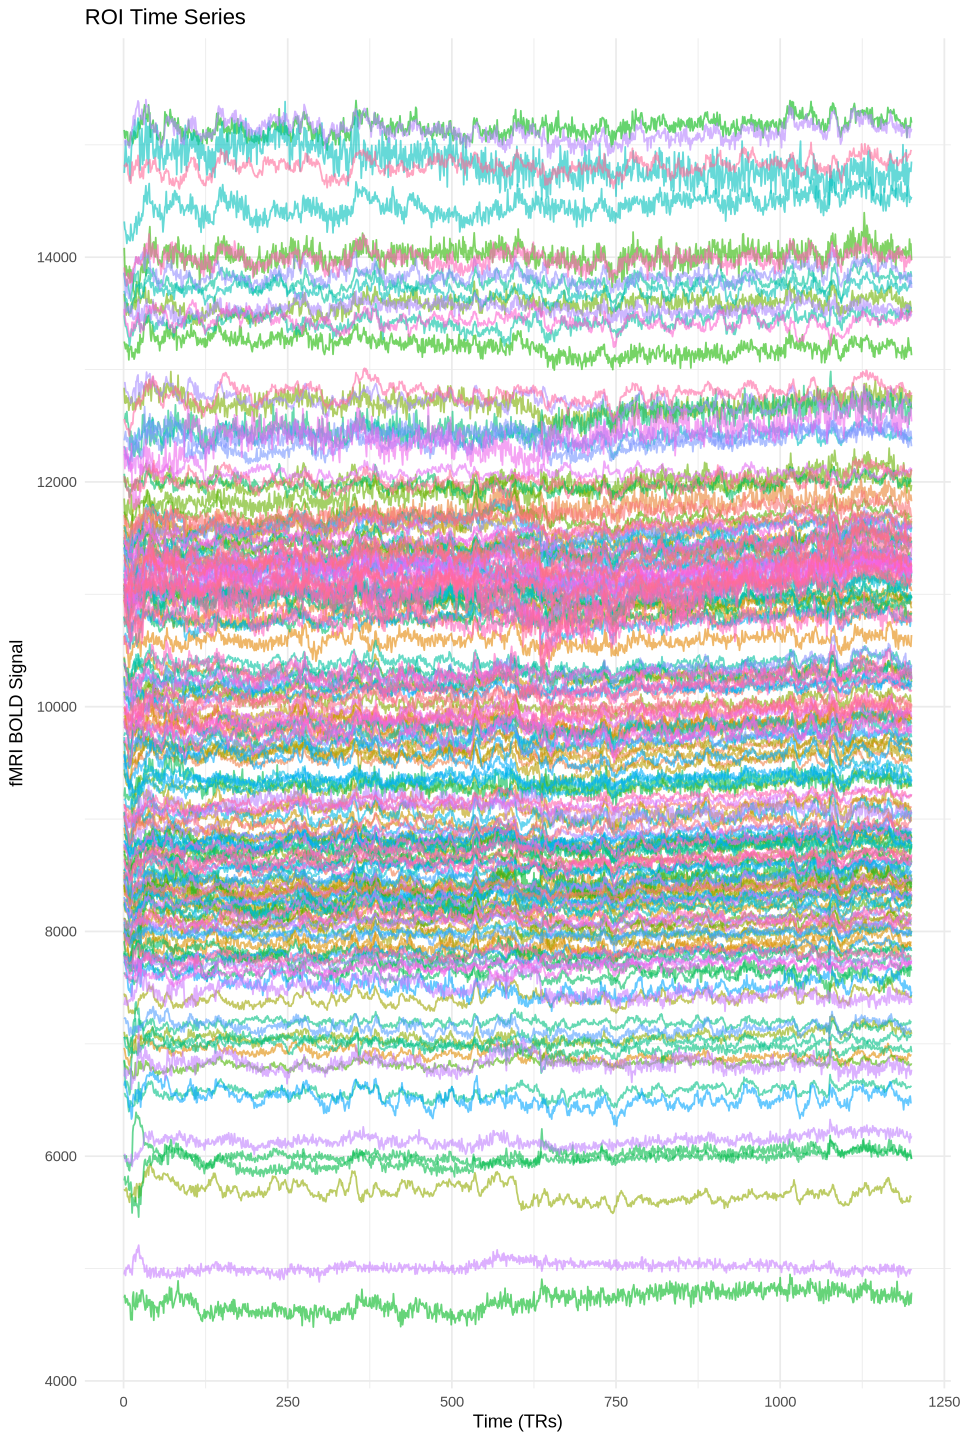

In [ ]:
# Add a Time column so we can create a nice labelled plot
df2 <- df
df2$Time <- 1:nrow(df2)

# Reshape data frame to long format
df_long <- pivot_longer(df2, 
                        cols = -Time, 
                        names_to = "Region", 
                        values_to = "Signal")
# Plot
ggplot(df_long, aes(x = Time, y = Signal, color = Region)) +
  geom_line(alpha = 0.6) +
  theme_minimal() +
  labs(title = "ROI Time Series", x = "Time (TRs)", y = "fMRI BOLD Signal") +
  theme(legend.position = "none")

### Normalize time series data

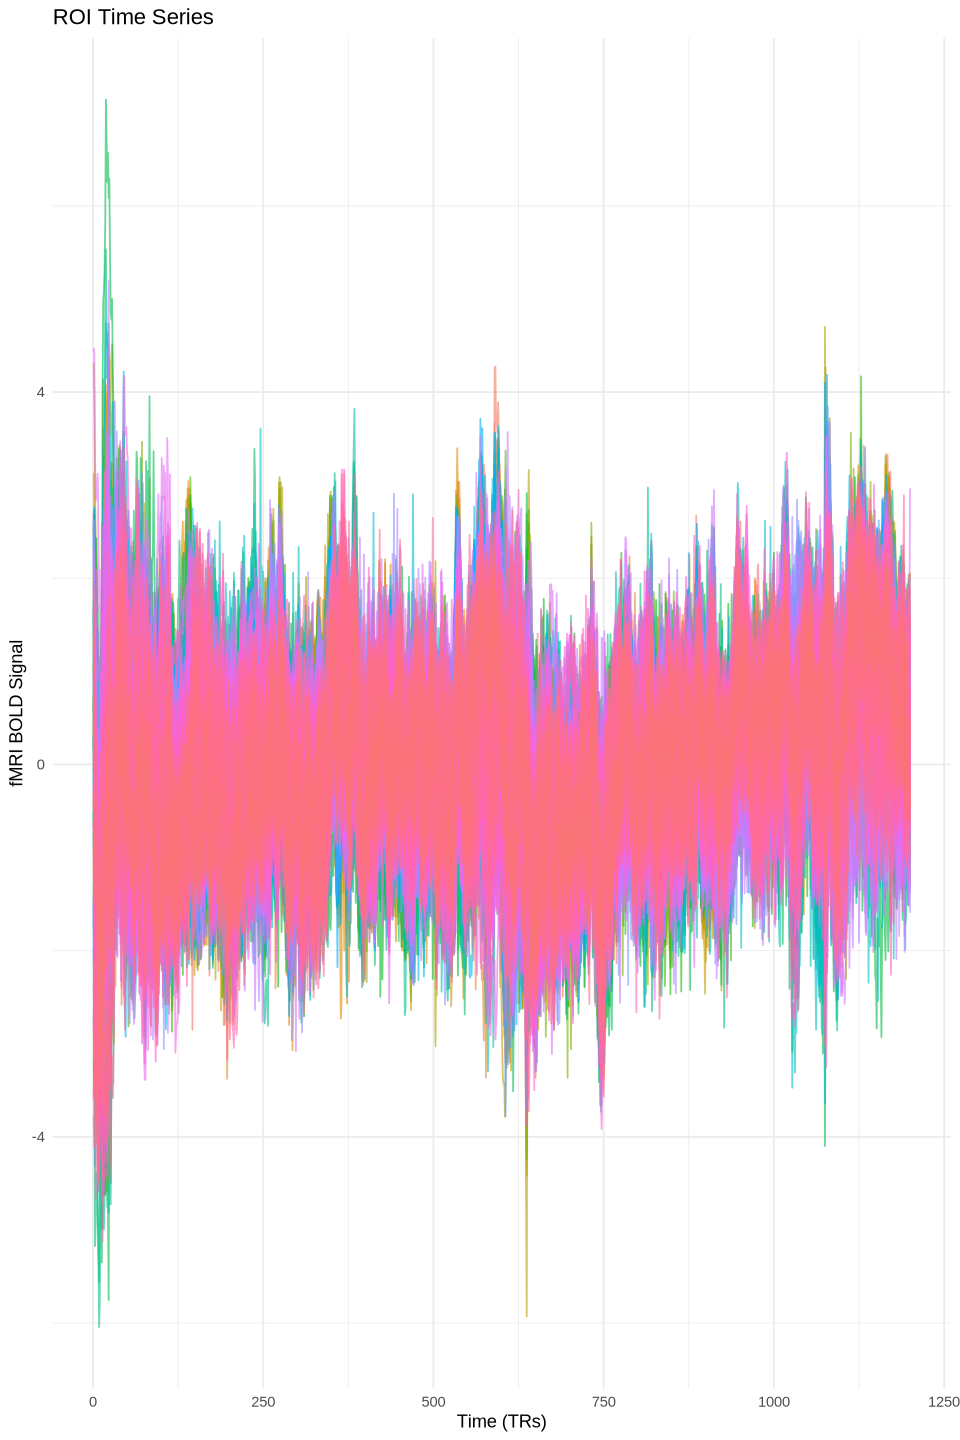

In [28]:
###First step: normalise their time series data
df_z <- scale(df, center = TRUE, scale = TRUE) 
df_z <- as.data.frame(df_z) #make data frame
  
#Plot df_z
# Add a Time column so we can create a nice labelled plot
df_z$Time <- 1:nrow(df_z)

#Reshape data frame to long format
df_z_long <- pivot_longer(df_z, 
                          cols = -Time, 
                          names_to = "Region", 
                          values_to = "Signal")
#Plot
options(repr.plot.height = 12, repr.plot.width = 8)
ggplot(df_z_long, aes(x = Time, y = Signal, color = Region)) +
  geom_line(alpha = 0.6) +
  theme_minimal() +
  labs(title = "ROI Time Series", x = "Time (TRs)", y = "fMRI BOLD Signal") +
  theme(legend.position = "none")

### Calculate their Functional Connectivity (FC) matrix
Let’s do some analyses on these data now! First thing, let’s calculate functional connectivity (FC). As a refresher, FC is a statistical construct derived (typically) as the Pearson’s correlation between pairs of brain regions. The output is therefore a region x region matrix where each entry indicates how strong the correlation is between two regions. In our case, our FC matrix will be 200x200.

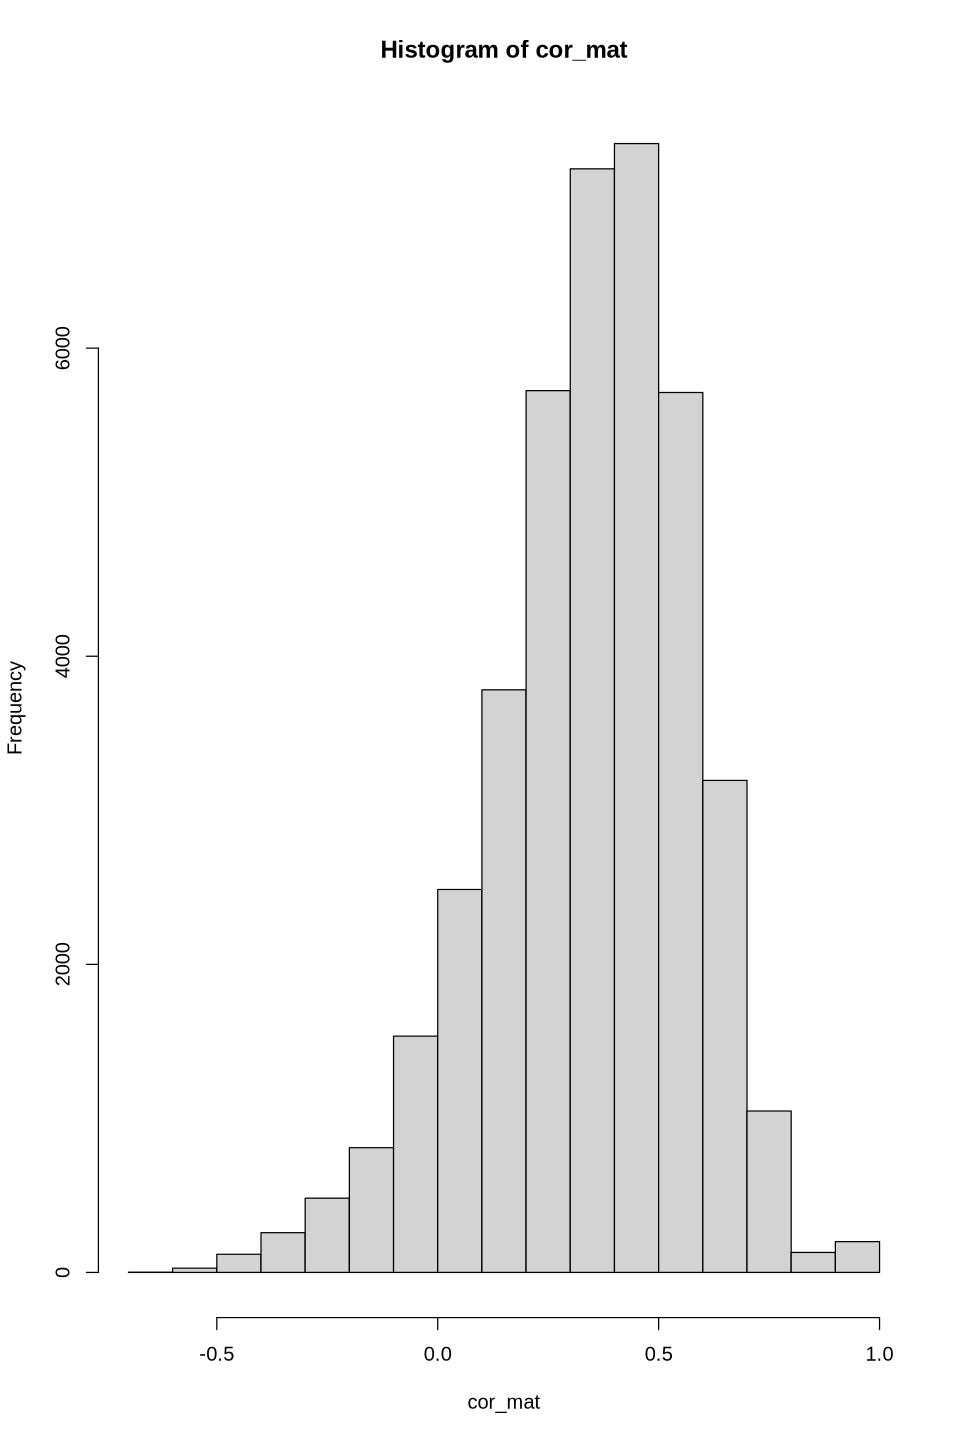

In [29]:
###Second step: calculate their FC matrix
matrix_df <- as.matrix(df) #convert to matrix format to do calculations

# Pearson's correlation
cor_mat <- cor(matrix_df) #compute FC on matrix format variable

#Look at distribution of FC values
hist(cor_mat) 

### Normalise FC values
For group analyses, we need to normalise these FC values: Fisher-z transformation

In [30]:
###Third step: normalise their FC values
z_mat <- atanh(cor_mat) 
# Clean matrix: replace Inf values that come from Fisher z-transform
z_mat[!is.finite(z_mat)] <- NA

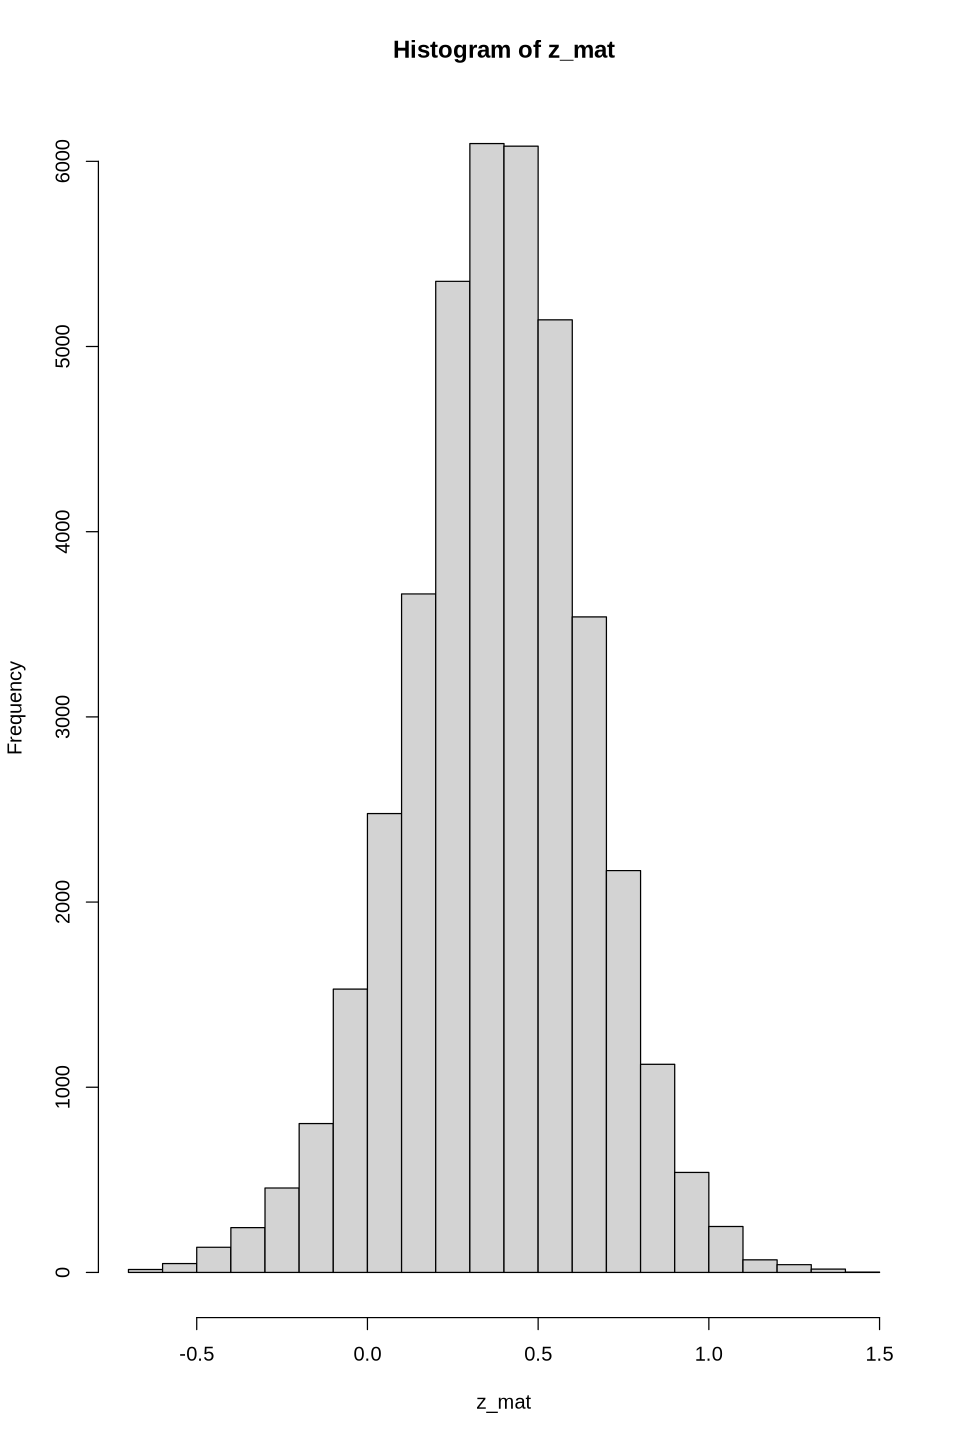

In [31]:
hist(z_mat)

In [24]:
# Check which rows/columns have any NA values
na_rows <- which(apply(cor_mat, 1, function(x) any(is.na(x))))
na_cols <- which(apply(cor_mat, 2, function(x) any(is.na(x))))

if (length(na_rows) > 0 || length(na_cols) > 0) {
  cat("Rows with NA:", na_rows, "\n")
  cat("Cols with NA:", na_cols, "\n")
}

# Optionally: remove them before z-transform
cor_mat_clean <- cor_mat[-na_rows, -na_cols]

# Now safe to apply Fisher z-transform
z_mat <- atanh(cor_mat_clean)

### Visualise FC matrix
You can play with the value limits, but in generally you want to make sure you see boxes in your matrix reflecting the brain’s functional network organisation.

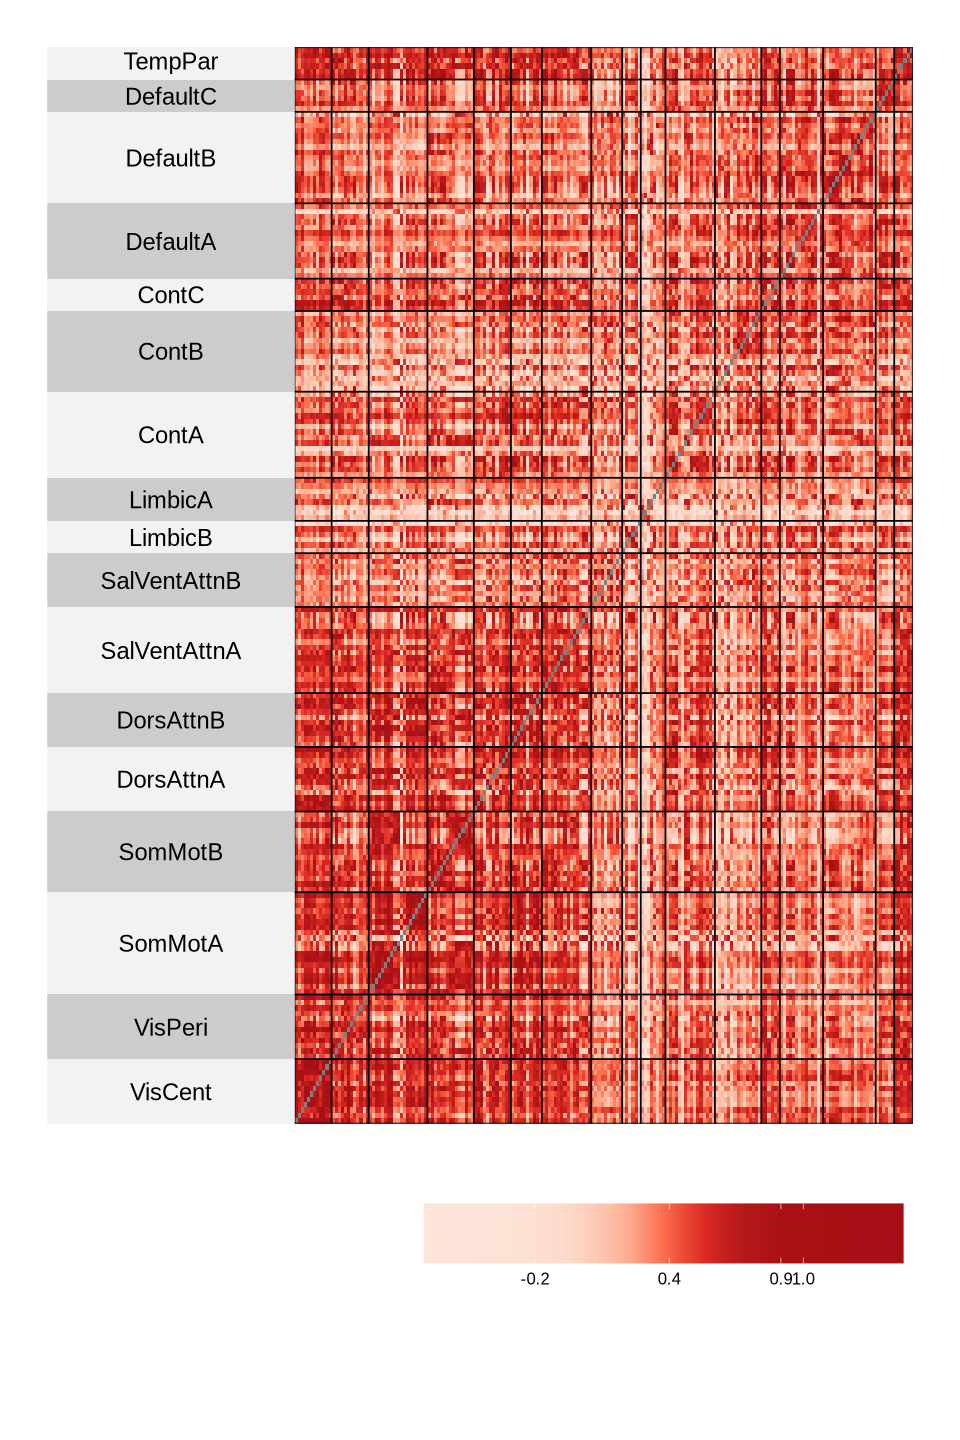

In [33]:
###Fourth step: roughly visualise their FC matrix

# Use these names to label your FC matrix
colnames(z_mat) <- atlas 
rownames(z_mat) <- atlas 

# Example: "17Networks_LH_VisCent_ExStr_1" → "VisCent"
networks <- sub("17Networks_.._([^_]+).*", "\\1", atlas)
networks <- factor(networks, levels = unique(networks))

reds <- colorRampPalette(c("#fee5d9", "#fcae91", "#fb6a4a", "#de2d26", "#a50f15"))(100)
superheat(z_mat,
          membership.rows = networks,
          membership.cols = networks,
          left.label.size = 0.4,
          bottom.label.size = 0,
          scale = FALSE,
          heat.pal = reds,
          # make the legend bigger
          legend.height = 0.25,
          legend.width = 2,
          legend.text.size = 10)




### Calculate Nodal strength
Let’s take this a step further. Let’s calculate how much each region is connected to the rest of the brain, a measure that is called node strength. [Node strength](https://sites.google.com/site/bctnet/list-of-measures), or region strength, is “the sum of weights of links connected to the node”. This will allow us to obtain a 1x200 vector that we can relate to a bunch of other measures of brain organisation.

In [34]:
###Fifth step: calculate nodal strength

node_strength <- rowSums(z_mat, na.rm = TRUE)

node_strength <- as.data.frame(node_strength)
rownames(node_strength) <- seq(1:200)

node_strength[,2] <- atlas

colnames(node_strength)[1] <- "Value"
colnames(node_strength)[2] <- "region"

merging atlas and data by 'region'



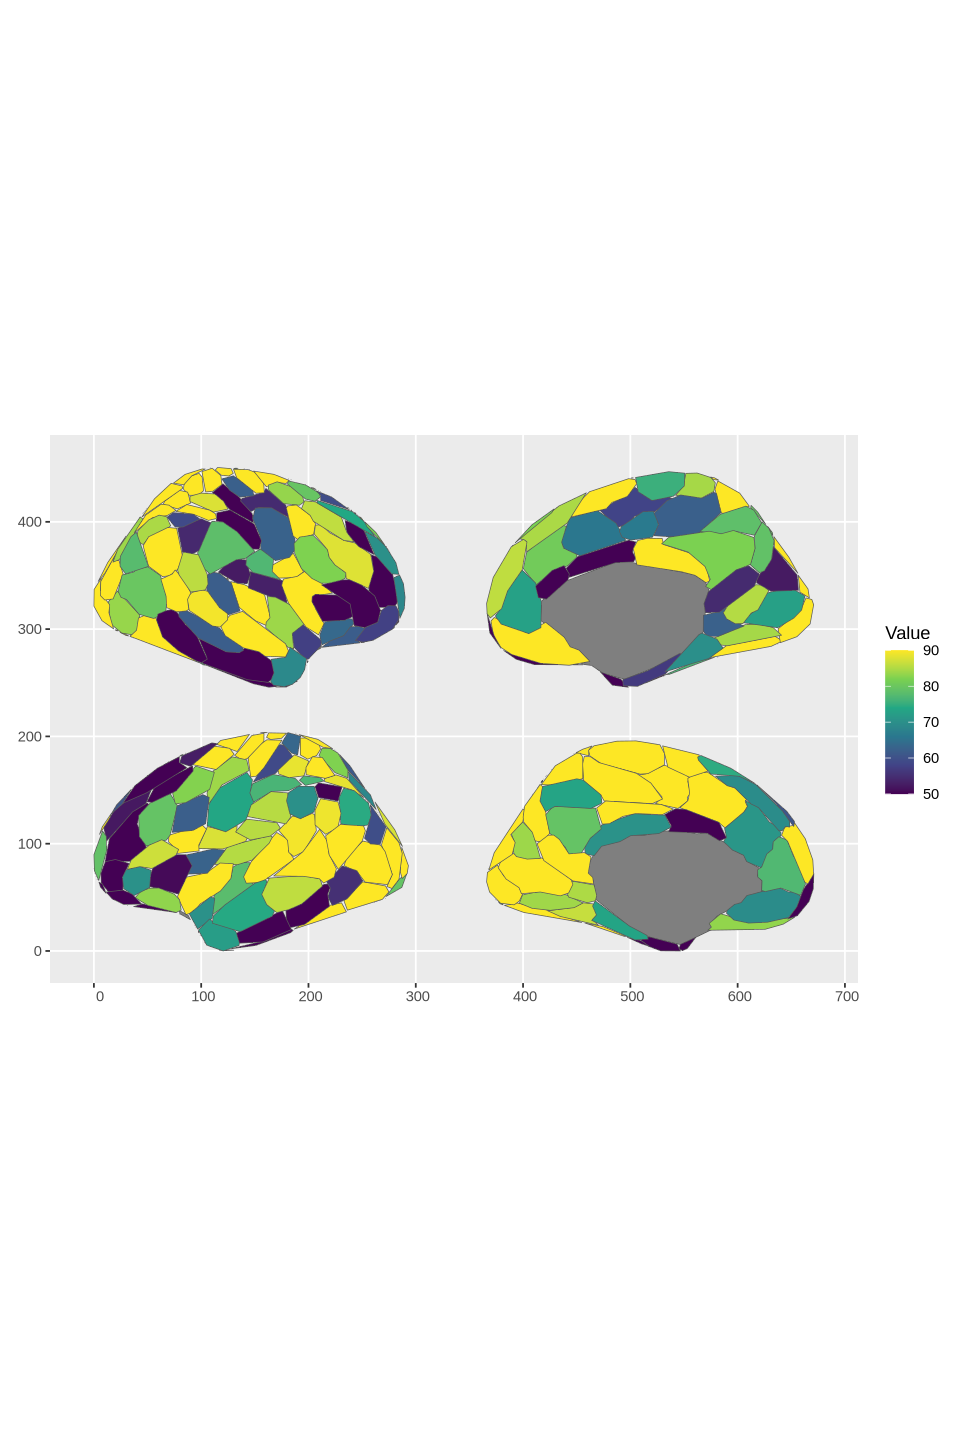

In [35]:
#Visualize
node_strength %>%
  ggplot() +
  geom_brain(atlas = schaefer17_200,
             position = position_brain(hemi ~ side),
             mapping = aes(fill=Value, geometry=geometry)) +
  scale_fill_viridis_c(limits = c(50, 90), oob = scales::squish)

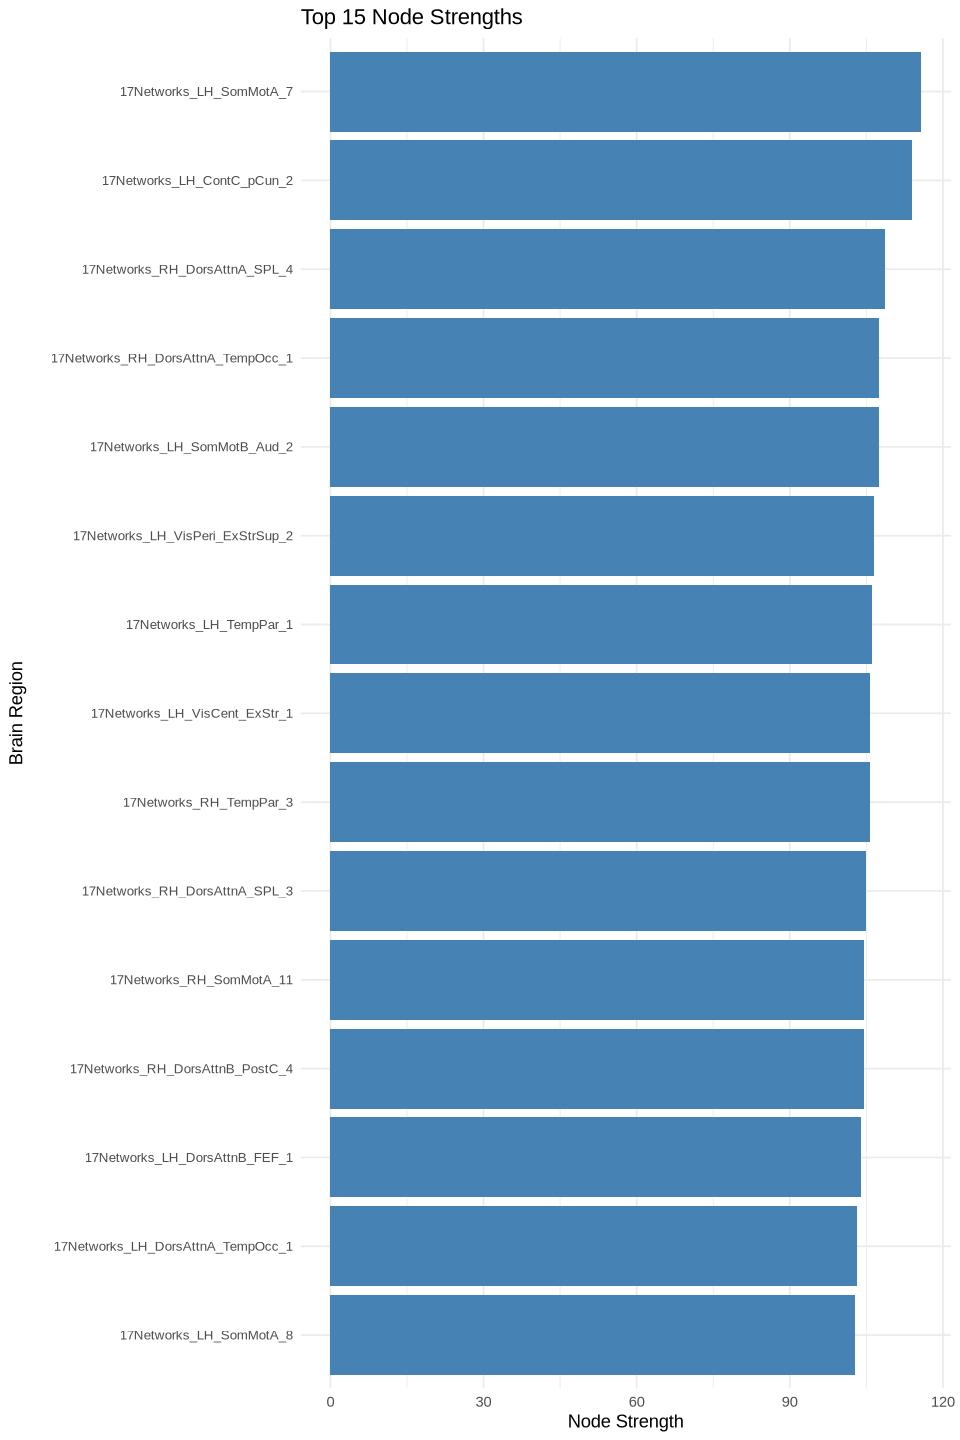

In [36]:
top_n <- 15  

node_strength %>%
  slice_max(Value, n = top_n) %>%
  ggplot(aes(x = reorder(region, Value), y = Value)) +
  geom_col(fill = "steelblue") +
  coord_flip() +
  labs(title = paste("Top", top_n, "Node Strengths"),
       x = "Brain Region",
       y = "Node Strength") +
  theme_minimal() +
  theme(axis.text.y = element_text(size = 8))


### Relate their nodal strength measures to measures of brain organisation and gene organisation

In [37]:
###Sixth step: relate their nodal strength measures to measures of brain organisation and gene organisation
brain_organisation <- read.csv("./data/margulies2016_fcgradient01_20017Schaefer.csv")
gene_organisation <- read.csv("./data/gene_pc1_20017Schaefer.csv")

merging atlas and data by 'region'

merging atlas and data by 'region'



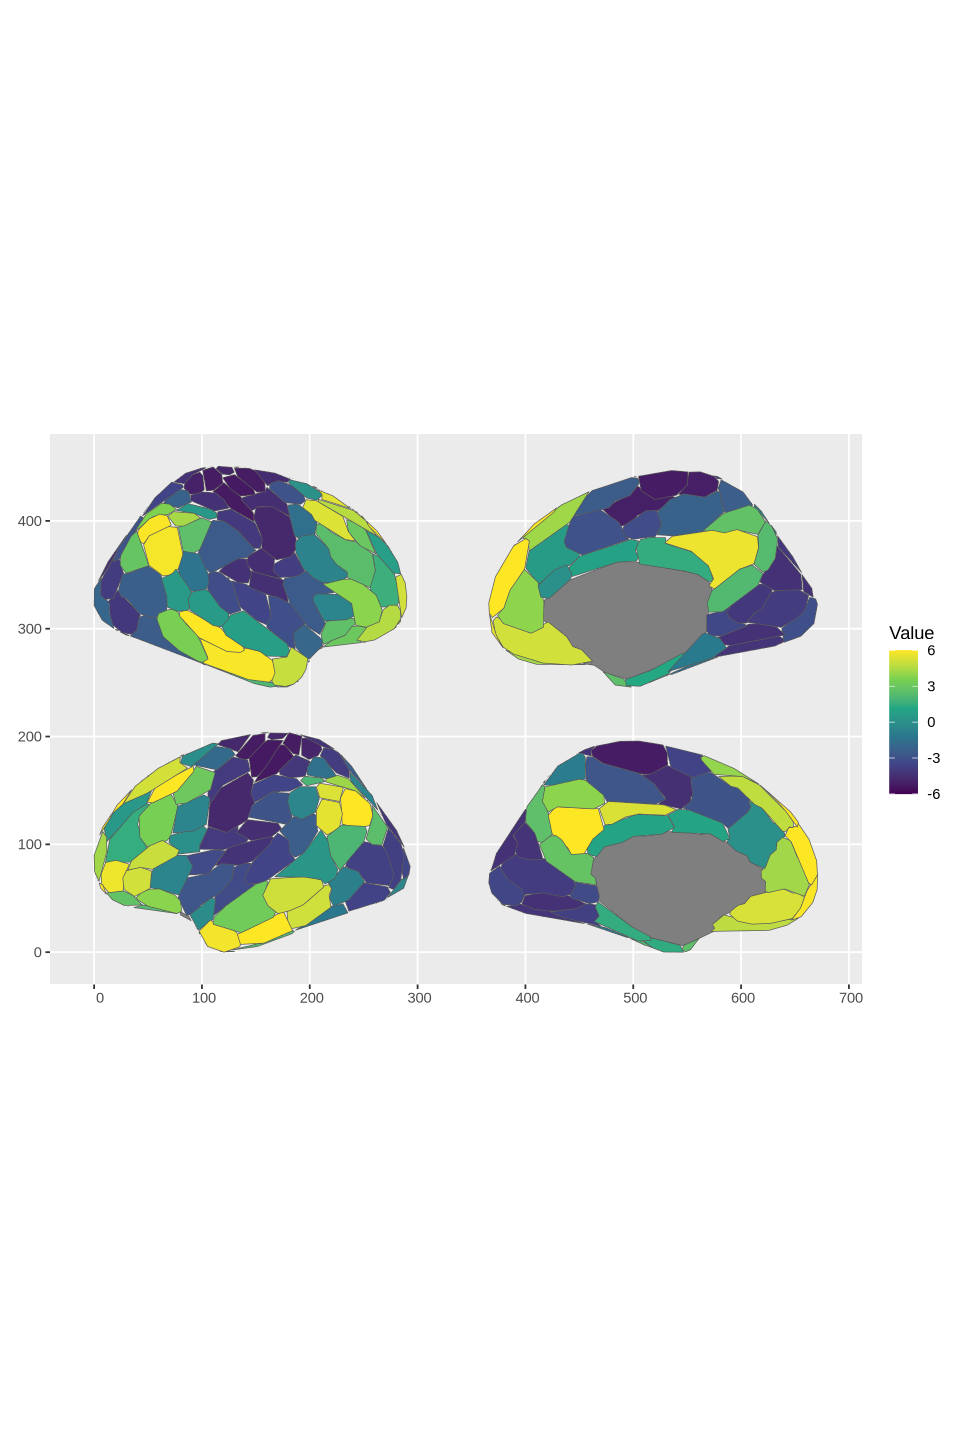

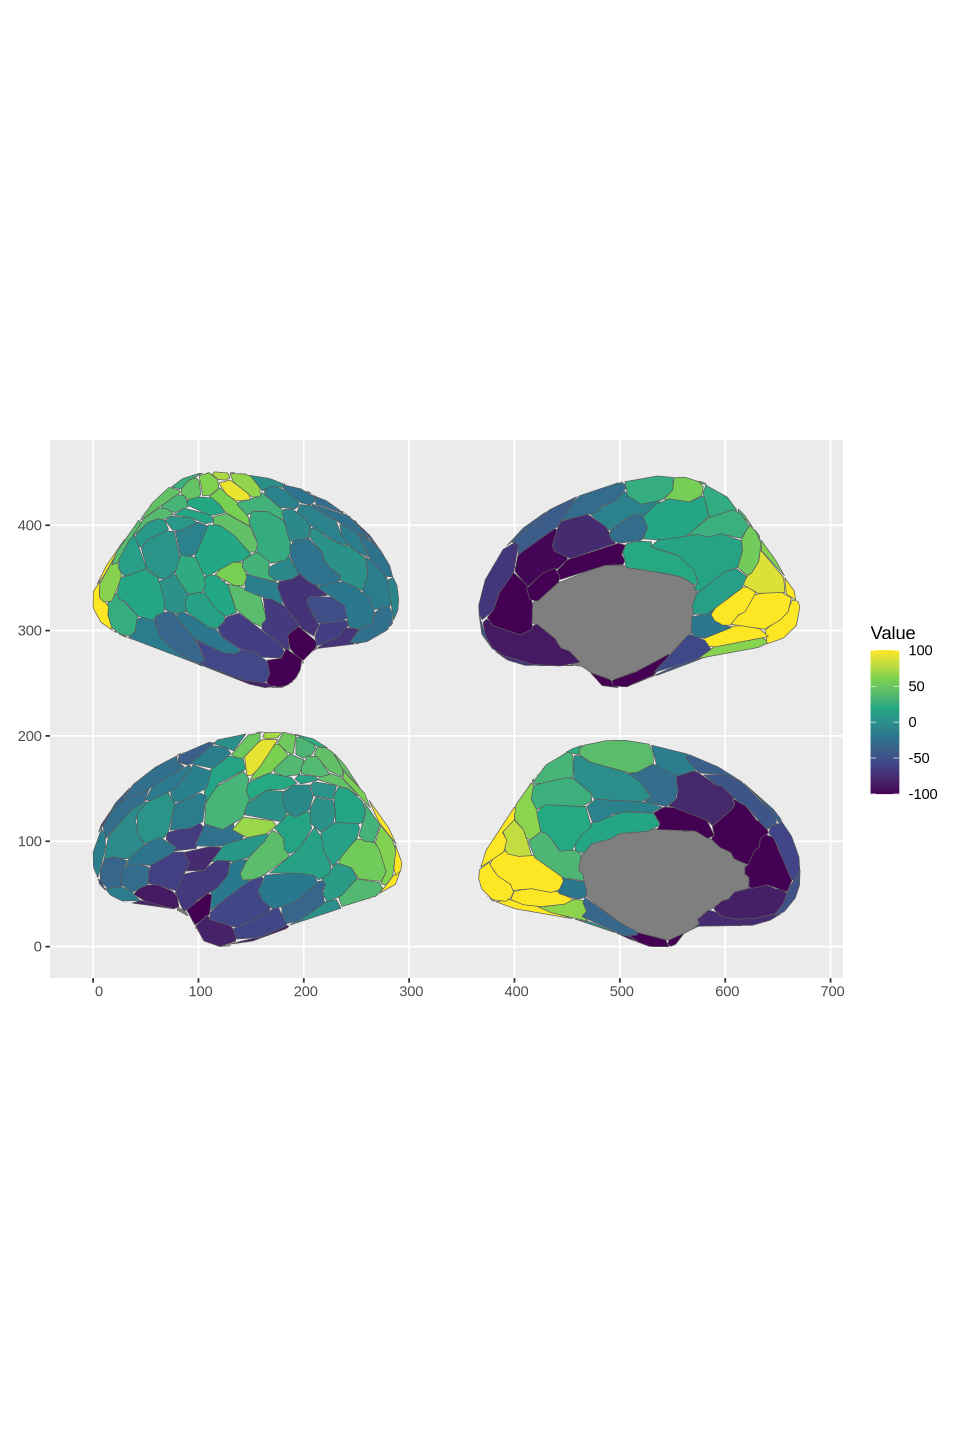

In [38]:
#visualise them both following node_strength plot above
brain_organisation %>%
  ggplot() +
  geom_brain(atlas = schaefer17_200,
             position = position_brain(hemi ~ side),
             mapping = aes(fill=Value, geometry=geometry)) +
  scale_fill_viridis_c(limits = c(-6, 6), oob = scales::squish)

gene_organisation %>%
  ggplot() +
  geom_brain(atlas = schaefer17_200,
             position = position_brain(hemi ~ side),
             mapping = aes(fill=Value, geometry=geometry)) +
  scale_fill_viridis_c(limits = c(-100, 100), oob = scales::squish)

In [39]:
#Compute correlation amongst these vectors: nodal strength, brain organisation and gene organisation
corr_node_brainorg <- cor(node_strength$Value,brain_organisation$Value, method = 'spearman') 
corr_node_geneorg <- cor(node_strength$Value,gene_organisation$Value, method = 'spearman')

In [42]:
# Put results into a data frame
cor_results <- data.frame(
  Comparison = c("Nodal Strength vs Brain Organisation",
                 "Nodal Strength vs Gene Organisation"),
  Spearman_rho = c(corr_node_brainorg, corr_node_geneorg)
)

library(knitr)
kable(cor_results, digits = 3, caption = "Spearman correlations for Nodal Strength")




Table: Spearman correlations for Nodal Strength

|Comparison                           | Spearman_rho|
|:------------------------------------|------------:|
|Nodal Strength vs Brain Organisation |       -0.359|
|Nodal Strength vs Gene Organisation  |        0.459|